In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

print(torch.cuda.is_available())

plt.rcParams['figure.figsize'] = (12,12)

True


In [3]:
data_path = Path('/home/gautham/kaggle/casava leaf')
base_dir = Path('/home/gautham/kaggle/wrapml/cassava')

In [4]:
from wrapml.utils import seed_everything

seed = seed_everything()

## Build Datasets

In [5]:
from wrapml.image_classification.dataset import ImageClassificationDataset
from wrapml.image_classification.transforms import get_train_transforms, get_valid_transforms

In [6]:
train = pd.read_csv(data_path/'train.csv')
label_map = pd.read_json(data_path/'label_num_to_disease_map.json', typ='series')

### Validation set building

**Strategies**

1. K-fold Stratify by label

In [7]:
from sklearn.model_selection import StratifiedKFold

In [10]:
_skf = StratifiedKFold(5, random_state=seed)

In [11]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [12]:
train = train.rename(columns={'image_id': 'img_path'})

In [13]:
img_size = 384

train_sample = train.sample(int(len(train)/10))

for train_index, valid_index in _skf.split(train_sample, train_sample['label']):
    train_dataset = ImageClassificationDataset(
        train.loc[train_index],
        data_path/'train_images/',
        True,
        get_train_transforms(img_size)
    )
    
    valid_dataset = ImageClassificationDataset(
        train.loc[valid_index],
        data_path/'train_images/',
        True,
        get_valid_transforms(img_size)
    )
    
    print(len(train_dataset), len(valid_dataset))

1711 428
1711 428
1711 428
1711 428
1712 427


## Build Dataloaders

In [14]:
from torch.utils.data import DataLoader

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=6)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=6)

In [16]:
x, y = next(iter(train_dataloader))
x.shape, y.shape

(torch.Size([4, 3, 384, 384]), torch.Size([4]))

## Construct Model

In [17]:
import timm
from pprint import pprint
model_names = timm.list_models()

In [16]:
model_names

['adv_inception_v3',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_vovnet39b',
 'ecaresnet18',
 'ecaresnet50',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'ecaresnext26tn_32x4d',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',


In [18]:
from wrapml.utils import freeze_until

In [19]:
# should be able to load from a file
# should be able to freeze layers and train

model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=5)

In [19]:
model = freeze_until(model, 'blocks.2.2.bn3.bias')

In [20]:
print(x.shape)
model(x).shape

torch.Size([4, 3, 384, 384])


torch.Size([4, 5])

## Lightning Module

In [21]:
from wrapml.image_classification.module import ImageClassificationModule
from wrapml.loss_function import SmoothCrossEntropyLoss

import pytorch_lightning as pl
import torch.nn as nn

In [22]:
ic_module = ImageClassificationModule(
    model,
    SmoothCrossEntropyLoss(smoothing=0.3),
    learning_rate=1e-4
)

## Lightning Trainer

In [23]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = 'EfficientNet-b3-sl'
model_dir = base_dir/f'models/{model_name}/'
log_dir = base_dir/'logs/'

model_dir.mkdir(exist_ok=True, parents=True)
log_dir.mkdir(exist_ok=True, parents=True)

mc = ModelCheckpoint(dirpath=model_dir, monitor='val_loss', save_top_k=3, save_last=True)

logger = TensorBoardLogger(
    save_dir=log_dir,
    version=1,
    name=model_name
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

trainer = pl.Trainer(
    auto_lr_find=False, 
    gpus=1,
    min_epochs=5,
    max_epochs=10,
    callbacks=[mc, early_stopping_callback],
    logger=logger
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### LR Finder

In [24]:
lr_finder = trainer.tuner.lr_find(
    ic_module, 
    train_dataloader=train_dataloader,
    min_lr=1e-6,
    max_lr=1e-2
) 


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EfficientNet     | 10.7 M
1 | loss_function | CrossEntropyLoss | 0     
2 | metrics       | Accuracy         | 0     
---------------------------------------------------
10.5 M    Trainable params
163 K     Non-trainable params
10.7 M    Total params


Restored states from the checkpoint file at /home/gautham/kaggle/wrapml/cassava/experiments/lr_find_temp_model.ckpt


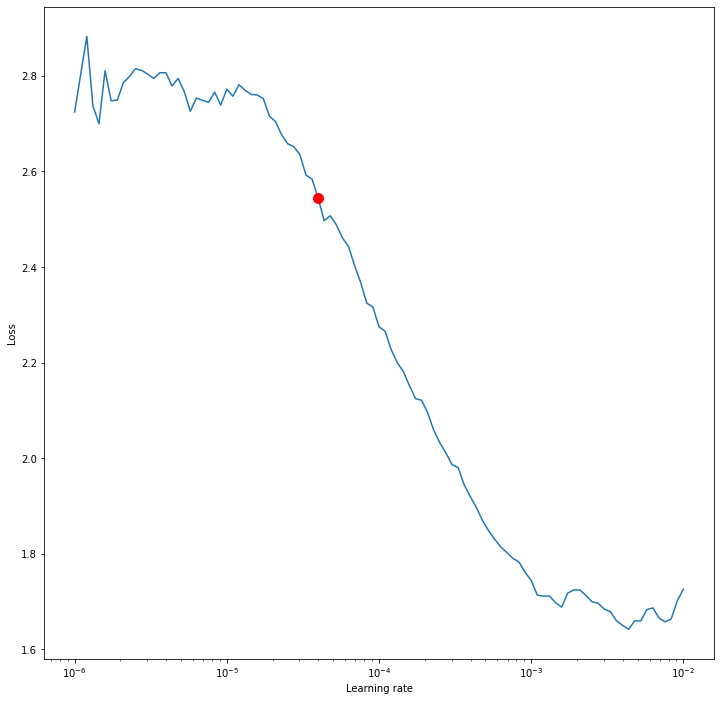

In [25]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [26]:
new_lr = lr_finder.suggestion()
new_lr

3.9810717055349735e-05

In [27]:
ic_module.hparams.lr = new_lr

## Training

In [ ]:
trainer.fit(
    ic_module,
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader,
)


  | Name          | Type                   | Params
---------------------------------------------------------
0 | model         | EfficientNet           | 10.7 M
1 | loss_function | SmoothCrossEntropyLoss | 0     
2 | metrics       | Accuracy               | 0     
---------------------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params


In [93]:
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    """
    With label smoothing,
    KL-divergence between q_{smoothed ground truth prob.}(w)
    and p_{prob. computed by model}(w) is minimized.
    """
    def __init__(self, label_smoothing, tgt_vocab_size):
        assert 0.0 < label_smoothing <= 1.0
        # self.ignore_index = ignore_index
        super(LabelSmoothingLoss, self).__init__()

        smoothing_value = label_smoothing / (tgt_vocab_size - 2)
        one_hot = torch.full((tgt_vocab_size,), smoothing_value)
        # one_hot[self.ignore_index] = 0
        self.register_buffer('one_hot', one_hot.unsqueeze(0))

        self.confidence = 1.0 - label_smoothing

    def forward(self, output, target):
        """
        output (FloatTensor): batch_size x n_classes
        target (LongTensor): batch_size
        """
        model_prob = self.one_hot.repeat(target.size(0), 1)
        model_prob.scatter_(1, target.unsqueeze(1), self.confidence)
        # model_prob.masked_fill_((target == self.ignore_index).unsqueeze(1), 0)

        return F.kl_div(output, model_prob, reduction='sum')
    
    

class LSL(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LSL, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
        
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss
    
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

In [100]:
lsl2 = LabelSmoothingCrossEntropy(0.3, 'mean')

In [101]:
lsl2(output, target)

tensor(1.0355)

In [136]:
log_preds = F.log_softmax(output, dim=-1)
loss = reduce_loss(-log_preds.sum(dim=-1), 'mean')

In [137]:
loss

tensor(3.3632)

In [127]:
output

tensor([[0.7000, 0.5000, 0.1000],
        [0.4000, 0.6000, 0.2000],
        [0.5000, 0.9000, 0.4000]])

In [118]:
log_preds

tensor([[-0.8619, -1.0619, -1.4619],
        [-1.1119, -0.9119, -1.3119],
        [-1.2228, -0.8228, -1.3228]])

In [126]:
target

tensor([0, 1, 0])

In [128]:
nll = F.nll_loss(log_preds, target, reduction='mean')

In [129]:
nll

tensor(0.9988)

In [139]:
linear_combination(loss/3, nll, 0.3)

tensor(1.0355)

In [134]:
np.log(.1)

-2.3025850929940455

In [88]:
lsl = LSL(3, 0.3)

In [89]:
lsl(output, target)

tensor(1.0538)

In [75]:
ls = LabelSmoothingLoss(0.3, 3)
target = torch.tensor([0,1,0])
output = torch.tensor([
    [0.7, 0.5, 0.1],
    [0.4, 0.6, 0.2],
    [0.5, 0.9, 0.4]
])

In [76]:
output

tensor([[0.7000, 0.5000, 0.1000],
        [0.4000, 0.6000, 0.2000],
        [0.5000, 0.9000, 0.4000]])

In [77]:
ls.confidence

0.7

In [78]:
ls.one_hot

tensor([[0.3000, 0.3000, 0.3000]])

In [79]:
model_prob = ls.one_hot.repeat(target.size(0), 1)

In [80]:
model_prob

tensor([[0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000]])

In [81]:
model_prob.scatter_(1, target.unsqueeze(1), ls.confidence)

tensor([[0.7000, 0.3000, 0.3000],
        [0.3000, 0.7000, 0.3000],
        [0.7000, 0.3000, 0.3000]])

In [82]:
F.kl_div(output, model_prob, reduction='sum')

tensor(-4.9262)

In [38]:
one_hot = torch.full((5,), 0.3)

In [41]:
model_prob = one_hot.repeat(8, 1)

In [45]:
model_prob.scatter_(1, torch.tensor([0,1,0,1,0,1,0,1]), 0.7)

RuntimeError: Index tensor must have the same number of dimensions as self tensor

In [140]:
import shutil

In [141]:
shutil.copytree?